>### Machine Learning by the Total Profit and getting evaluate the model performance

- In this section, we will create a model which going to evaluate performance features a **Total Profit** by the model

---
### List of Machine Learning Algorithms
- **Random Forest**

- **XGBoost**

- **LightGBM**
---

---
#### Cleaning & Preparing Data

In [1]:
from sklearn.model_selection import cross_val_score, train_test_split,KFold,RandomizedSearchCV,GridSearchCV,cross_validate
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import model_selection
sns.set_style('darkgrid')
df = pd.read_csv('Dataset.csv')
df.head()

,REGION,COUNTRY,ITEM_TYPE,SALES_CHANNEL,QUALITY_PRODUCT,ORDER_DATE,ORDER_ID,SHIP_DATE,UNITS_SOLD,UNIT_PRICE,UNIT_COST,TOTAL_COST,TOTAL_PROFIT
0,Middle East and North Africa,Morocco,Vegetables,Online,M,29.01.16,371943700,12.03.16,5261,154.06,90.93,478382.73,332126.93
1,Middle East and North Africa,Somalia,Furniture,Online,H,07.10.12,366155707,23.10.12,2465,668.27,502.54,1238761.10,408524.45
2,Europe,Azerbaijan,Cosmetics,Offline,L,11.06.15,714965188,26.06.15,2942,437.20,263.33,774716.86,511525.54
3,Europe,Moldova,Clothes,Offline,H,21.05.13,290295970,25.05.13,3883,109.28,35.84,139166.72,285167.52
4,Europe,Italy,Optical instruments,Online,C,02.02.12,284384381,10.02.12,6513,152.58,97.44,439746.72,248846.82


#### Droping few variable which has least impact on Total Profit

In [2]:
df.drop(['SALES_CHANNEL','REGION','QUALITY_PRODUCT','COUNTRY','ITEM_TYPE','SHIP_DATE','ORDER_DATE','ORDER_ID'],axis=1,inplace=True)

#### SPLITTING DATASET TO TRAIN AND TEST SET AND APPLYING SOME FEATURE ENGINEERING TECHNIQUES

In [3]:
X=df.drop('TOTAL_PROFIT',axis=1)
y=df['TOTAL_PROFIT']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)

train_set=pd.concat([X_train,y_train],axis=1)
test_set=pd.concat([X_test,y_test],axis=1)

In [4]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', X_test.shape)
print('Testing Features Shape:', y_train.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (85627, 4)
Training Labels Shape: (9515, 4)
Testing Features Shape: (85627,)
Testing Labels Shape: (9515,)


#### APPLYING TARGET MEAN ENCODING FOR CATEGORICAL FEATURES AND SCALING THE TRAIN AND TEST SET

In [5]:
categorical_features=[feature for feature in df.columns if df[feature].dtype=='O']
numerical_features=[feature for feature in df.columns if df[feature].dtype!='O']

In [6]:
for feature in categorical_features:
    feature_labels=train_set.groupby(feature)['TOTAL_PROFIT'].mean().sort_values().index
    feature_labels={k:i for i,k in enumerate(feature_labels,0)}
    train_set[feature]=train_set[feature].map(feature_labels)
    test_set[feature]=test_set[feature].map(feature_labels)

test_set.dropna(inplace=True)

scaler=StandardScaler()

scaled_X_train=pd.DataFrame(scaler.fit_transform(train_set.drop('TOTAL_PROFIT',axis=1)), columns=X_train.columns)
scaled_X_train.index=train_set.index
scaled_X_test=pd.DataFrame(scaler.transform(test_set.drop('TOTAL_PROFIT',axis=1)), columns=X_test.columns)
scaled_X_test.index=test_set.index


scaled_train=pd.concat([scaled_X_train,train_set['TOTAL_PROFIT']],axis=1)
scaled_test=pd.concat([scaled_X_test,test_set['TOTAL_PROFIT']],axis=1)

#### FEATURE SELECTION

#### Check feature importances using Random Forest & XGBoost & Light GBM

#### Feature importances using Random Forest algorithm

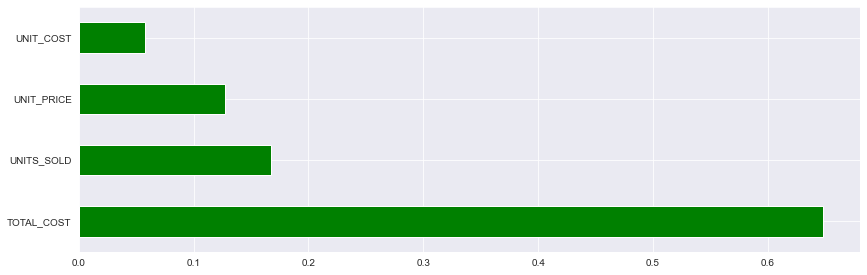

In [10]:
fig =  plt.figure(figsize = (14,4.5))
reg=RandomForestRegressor()
reg.fit(scaled_train.drop('TOTAL_PROFIT',axis=1),scaled_train['TOTAL_PROFIT'])
feat_importances = pd.Series(reg.feature_importances_, index=scaled_train.drop('TOTAL_PROFIT',axis=1).columns)
feat_importances.nlargest(scaled_train.drop('TOTAL_PROFIT',axis=1).shape[1]).plot(kind='barh',color='green')
plt.show()

#### Feature importances using XGBoost algorithm

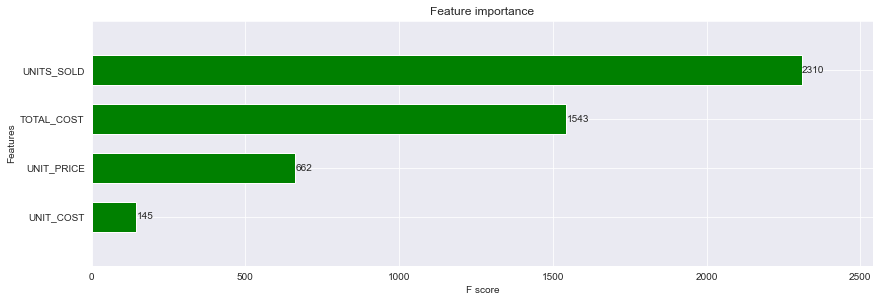

In [13]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
fig =  plt.figure(figsize = (14,4.5))
axes = fig.add_subplot(111)
xgb.plot_importance(model,ax = axes,height = 0.6,color='green',max_num_features=10)
plt.show()

#### Feature importances using LightGBM algorithm

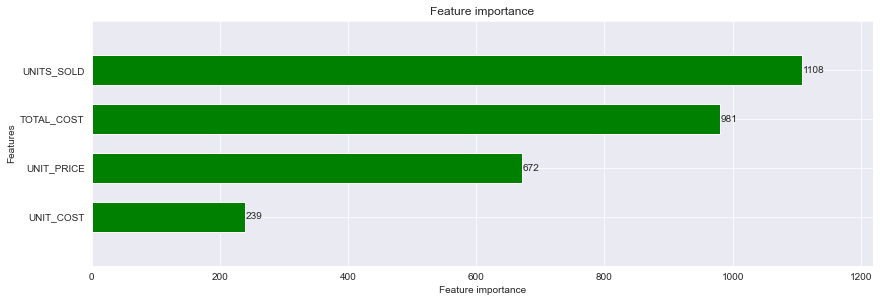

In [14]:
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)
fig =  plt.figure(figsize = (14,4.5))
axes = fig.add_subplot(111)
lgb.plot_importance(model,ax = axes,height = 0.6,color='green',max_num_features=10)
plt.show()

#### Εvaluating best model's performance according to K-fold

In [17]:
X_train=scaled_train.drop('TOTAL_PROFIT',axis=1)
y_train=scaled_train['TOTAL_PROFIT']
X_test=scaled_test.drop('TOTAL_PROFIT',axis=1)
y_test=scaled_test['TOTAL_PROFIT']

kfold = KFold(n_splits=10, random_state=None, shuffle=False)
rf=RandomForestRegressor()
xgb_reg=xgb.XGBRegressor()
lgb_reg=lgb.LGBMRegressor()
results = model_selection.cross_val_score(rf, X_train, y_train, cv=kfold)
results1 = model_selection.cross_val_score(xgb_reg, X_train, y_train, cv=kfold)
results2 = model_selection.cross_val_score(lgb_reg, X_train, y_train, cv=kfold)
print("Accuracy of Random Forest Model: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))
print("Accuracy of XGBoost Model: %.3f%% (%.3f%%)" % (results1.mean()*100.0, results1.std()*100.0))
print("Accuracy of LightGBM Model: %.3f%% (%.3f%%)" % (results2.mean()*100.0, results2.std()*100.0))

Accuracy of Random Forest Model: 94.632% (5.432%)
Accuracy of XGBoost Model: 96.620% (3.311%)
Accuracy of LightGBM Model: 96.572% (5.436%)


#### Evaluating the model's performance on the test set using regression metrics (MSE, MAE, RMSE, R2)

In [7]:
X_train=scaled_train.drop('TOTAL_PROFIT',axis=1)
y_train=scaled_train['TOTAL_PROFIT']
X_test=scaled_test.drop('TOTAL_PROFIT',axis=1)
y_test=scaled_test['TOTAL_PROFIT']

rf=RandomForestRegressor()
xgb_reg=xgb.XGBRegressor()
lgb_reg=lgb.LGBMRegressor()

score_rf=-np.round(cross_val_score(rf,X_train,y_train,cv=10,scoring='neg_mean_squared_error'),4)
score_xgb_reg=-np.round(cross_val_score(xgb_reg,X_train,y_train,cv=10,scoring='neg_mean_squared_error'),4)
score_lgb_reg=-np.round(cross_val_score(lgb_reg,X_train,y_train,cv=10,scoring='neg_mean_squared_error'),4)

mae_rf = -np.round(cross_val_score(rf, X_train,y_train, scoring='neg_mean_absolute_error', cv=10),4)
mae_xgb = -np.round(cross_val_score(xgb_reg, X_train,y_train, scoring='neg_mean_absolute_error', cv=10),4)
mae_lgb = -np.round(cross_val_score(lgb_reg, X_train,y_train, scoring='neg_mean_absolute_error', cv=10),4)

r2_rf = np.round(cross_val_score(rf, X_train,y_train, scoring='r2', cv=10),4)
r2_xgb = np.round(cross_val_score(xgb_reg, X_train,y_train, scoring='r2', cv=10),4)
r2_lgb = np.round(cross_val_score(lgb_reg, X_train,y_train, scoring='r2', cv=10),4)

rmse_rf = np.round(cross_val_score(rf, X_train, y_train,  scoring="neg_mean_squared_error", cv = 10),4)
rmse_xgb = np.round(cross_val_score(xgb_reg, X_train, y_train,  scoring="neg_mean_squared_error", cv = 10),4)
rmse_pl = np.round(cross_val_score(lgb_reg, X_train, y_train,  scoring="neg_mean_squared_error", cv = 10),4)

scores=pd.DataFrame({'Model':['Random Forest','XGBoost','LightGBM'],
                    'Mean Squared Error':[score_rf.mean(),score_xgb_reg.mean(),score_lgb_reg.mean()],
                    'Mean Absolute Error':[mae_rf.mean(),mae_xgb.mean(),mae_lgb.mean()],
                     'RMSE':[np.sqrt((-1)*np.mean(rmse_rf)),np.sqrt((-1)*np.mean(rmse_xgb)),np.sqrt((-1)*np.mean(rmse_pl))],
                     'R2':[r2_rf.mean(),r2_xgb.mean(),r2_lgb.mean()]})

scores

,Model,Mean Squared Error,Mean Absolute Error,RMSE,R2
0,Random Forest,7.543150e+09,1523.34419,90407.448944,0.94572
1,XGBoost,5.348811e+09,3630.34167,73135.563005,0.96621
2,LightGBM,5.763946e+09,6251.48576,75920.653856,0.96572


---
After getting estimated machine learning models result we can compare all our models to choose a better-estimated model and that is the Random Forest model, the reason is that some metrics as, RMSE,MSE and other measures highly than other models